# 3.1 Station Observations

```{note}
The code for downloading ECCC weather station data in this section was adapted from Section 4.1 of {cite:t}`anderson_narrative_2021`.
```

## 3.1.1 Downloading and Data Cleaning

For many practical applications, expecially in fields like engineering design, it is common practice to use observations at a nearby weather station to calculate the relevant climate indicators for a piece of infrastructure. Environment and Climate Change Canada (ECCC) has historical station observations available for hundreds of weather stations in Canada. The comprehensive list of stations, including their names, locations, and unique Station ID codes, can be found in the ``Station Inventory EN.csv`` file in [this Google Drive](https://drive.google.com/drive/folders/1WJCDEU34c60IfOnG4rv5EPZ4IhhW9vZH)

This notebook will show you how to download ECCC weather station observational data, plot some time series of climate variables, and calculate climatologies and extreme values. The above Google Drive includes instructions on how to download the data files using shell scripting, but here we will use the Python package ``ec3`` to download the data in an easier way. [The source code and limited documentation for this module can be found on GitLab](https://gitlab.com/claut/ec3.py).

First we'll import the necessary Python packages

In [1]:
import numpy as np
import scipy.stats as stats 
import matplotlib.pyplot as plt
import pandas as pd
import ec3

Next we'll make a list IDs for the stations we want to download. ECCC identifies each weather station with a Station ID, in addition to a name and coordinates. Each row in ``Station Inventory EN.csv`` corresponds to a different Station ID, though some stations have their Station ID (and possibly their name) changed over time. ``ec3.find_station`` is a function which can find all the stations that fit given search parameters. Calling ``help`` on this function will display the arguments it takes.

In [2]:
help(ec3.find_station)

Help on function find_station in module ec3:

find_station(name=None, province=None, period=None, type=None, detect_recodes=False, target=None, dist=range(0, 101))
    Find data available in the Environment and Climate Change Canada
    historical data archive
    
    Optional Parameters
    ----------
    name : str
        A pattern by which to filter station names.
    province : list or str
        One of more two-letter province codes, e.g. ON
    period : int or range
        Range of years for which data must be available
    type : int or str
        The type of data to search for (required if period is not None)
        Options are: 1, hourly; 2, daily; 3, monthly
    detect_recodes : Boolean
        Whether to try to detect stations that have been recoded when
        searching for stations that provide enough data for period.
    target : tuple or int
        Either the station code of a target station, or a tuple of
        latitude and longitude to use as a target.
    di

As an example, we will search for stations within 25 km of the latitude and longitude which come up when you Google search "Toronto latitude and longitude", and try to download data at daily frequency for the 30-year period 1992-2021. Passing the keyword argument ``detect_recodes = True`` will allow the function to print out combinations of station IDs that correspond to the same station. Data from these different Station IDs can be combned to form a single long-term record for that location.

In [3]:
toronto_lat = 43.6532
toronto_lon = -79.3832 # convention is degrees West are negative in a (180 W, 180 E) convention.
find_stn_results = ec3.find_station(target = (toronto_lat, toronto_lon), 
                                    period = range(1992, 2022),
                                    type = 'daily',
                                    dist = range(25),
                                    detect_recodes = True)
print(find_stn_results)

/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/ec3.py:105: UserWarning: Cannot find the station inventory in the current working directory.
  warnings.warn("Cannot find the station inventory in the current working directory.")


Note: In addition to the stations found, the following combinations may provide sufficient baseline data.


>> Combination 1 at coordinates 43.63 -79.4 

Station 5085 : TORONTO ISLAND A (1957-2006)
Station 5086 : TORONTO IS A (AUT) (1973-1973)
Station 30247 : TORONTO CITY CENTRE (2006-2014)
Station 48549 : TORONTO CITY CENTRE (2010-2023)


>> Combination 2 at coordinates 43.67 -79.4 

Station 5051 : TORONTO (1840-2017)
Station 31688 : TORONTO CITY (2002-2023)
Station 41863 : TORONTO SOLAR RADIATION (2018-2018)


>> Combination 3 at coordinates 43.68 -79.63 

Station 5097 : TORONTO LESTER B. PEARSON INT'L A (1937-2013)
Station 51459 : TORONTO INTL A (2013-2023)


>> Combination 4 at coordinates 43.86 -79.37 

Station 4841 : TORONTO BUTTONVILLE A (1986-2015)
Station 53678 : TORONTO BUTTONVILLE A (2015-2019)
Station 54239 : TORONTO BUTTONVILLE A (2018-2023)


No results!
None


In [4]:
stn_ids_toronto_city = [5051, 31688, 41863]

The search returned no results, because no single Station ID fit all of the search criteria. Luckily, the ``detect_recodes`` option returned 4 combinations of Station IDs which could be used. For simplicity, we will proceed using Combination 2, the downtown Toronto station.

The function ``ec3.get_data`` will download the data for a given Station ID at a specified time frequency (daily by default) and year range, and return it in a Pandas ``pd.DataFrame`` object. However, the data is not necessarily in the best format for further analysis. In particular, the column name for the daily mean temperature is ``'Mean Temp (°C)'``, which contains a non-standard character, and many of the column names contain spaces, which isn't ideal for working with Pandas. Additionally, the dates are stored as strings, but for calculating climatologies or selecting certain date ranges, it's much more convenient to work with a Python datetime object, which can intelligently handle different units of time.

Below is a function which wraps ``ec3.get_data`` and performs some of the data cleaning described above on a select few variables. If you are interested in a variable not listed, such as wind speed, you can use ``ec3.get_data`` by itself and perform any necessary data cleaning afterwards.

In [5]:
def download_station_data(stn_id, years = range(1992, 2022)):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'Date', 
                        'Max Temp (°C)': 'MaxTemp', 
                        'Min Temp (°C)': 'MinTemp',
                        'Mean Temp (°C)': 'MeanTemp',
                        'Total Precip (mm)': 'TotalPrecip',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only the variables we re-named - you can comment this out if you want to keep all variables
    df = df[list(column_name_dict.values())]
    
    # set the "Date" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    return df
    

In [6]:
# iterate through the station ID list and store the results in a dictionary, with keys being the station IDs
df_dict = {} 
for stn_id in stn_ids_toronto_city:
    df_dict[stn_id] = download_station_data(stn_id)

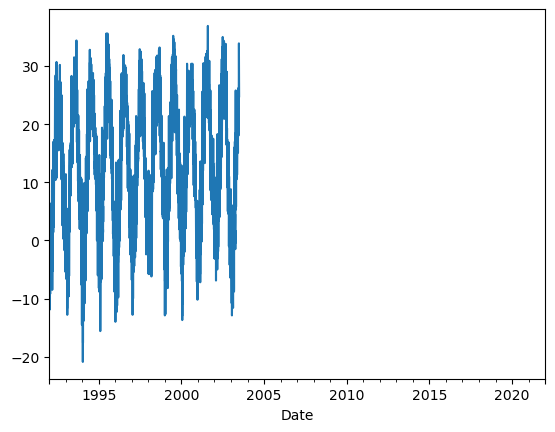

In [7]:
# take a peek at the daily max temperature data for the first station ID
plt.figure()
df_dict[stn_ids_toronto_city[0]].MaxTemp.plot.line()
plt.show()

The plot shows that the data for the Station ID 5051 ends in the early 2000s, which isn't exactly what was stated in the output of ``ec3.find_station``. Let's check exactly when the daily data for each of the three Station IDs starts and ends, by dropping NaNs and then finding the min and max date values.

In [8]:
# check the first and last time stamps for the records for each station ID
for stn_id in stn_ids_toronto_city:
    df = df_dict[stn_id].dropna(inplace = False)
    print(stn_id, df.index.min(), df.index.max())

5051 1992-01-01 00:00:00 2003-06-30 00:00:00
31688 2002-06-04 00:00:00 2021-12-31 00:00:00
41863 NaT NaT


Looks like the Station ID 41863 has no daily data at all, so we can now disregard it. We have now identified a new issue, and it's that the end of the Station ID 5051 record overlaps the Station ID 31688 record by almost a year. Let's plot the daily maximum temperature for each of these stations during their overlapping period, to see if they are just repeats of the same measurements, or at least close to each other.

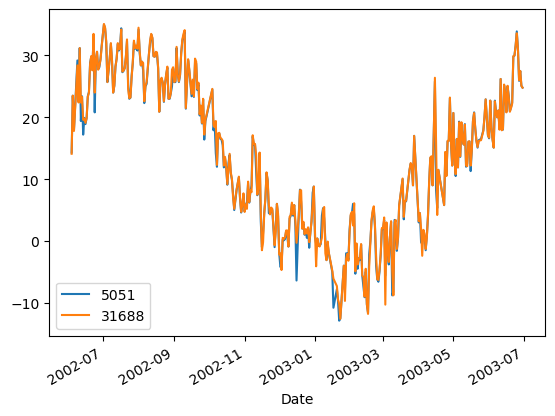

In [9]:
df1 = df_dict[stn_ids_toronto_city[0]].dropna(inplace = False)
df2 = df_dict[stn_ids_toronto_city[1]].dropna(inplace = False)

df1_overlap_period = df1[df1.index.isin(df2.index)]
df2_overlap_period = df2[df2.index.isin(df1.index)]


plt.figure()
df1_overlap_period.MaxTemp.plot.line(label = str(stn_ids_toronto_city[0]))
df2_overlap_period.MaxTemp.plot.line(label = str(stn_ids_toronto_city[1]))
plt.legend()
plt.show()

The data from the two sources agree very well during the overlapping period, though are not perfectly identical. Perhaps there was an instrument change that led to the ID change in the first place, it's difficult to know. Regardless, in a situtation like this it should be safe to choose the data from either record. We will choose the data from Station ID 31688 because it contribues to a greater proportion of the chosen time period. Now that all of the data cleaning is finished, let's plot at the daily maximum temperature over the whole record.

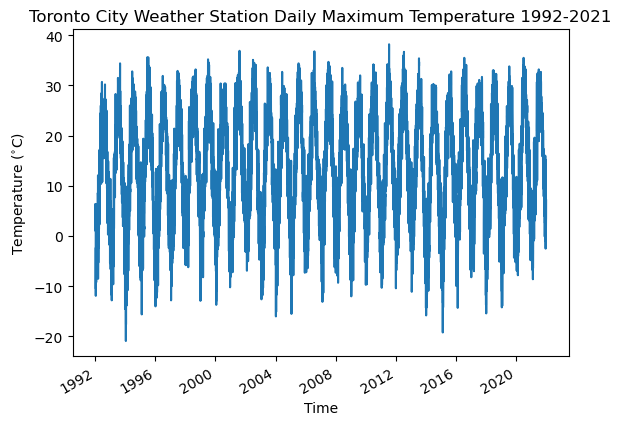

In [10]:
# merge the data from different station IDs into a single dataframe, dropping the data from df1 that overlaps
# with the record of df2
df_toronto_city = pd.concat([df1[df1.index < df2.index.min()], df2])


# plot time series of daily max temperature for the whole record
plt.figure()
plt.title("Toronto City Weather Station Daily Maximum Temperature 1992-2021")
df_toronto_city.MaxTemp.plot.line()
plt.ylabel(r'Temperature ($^{\circ}$C)')
plt.xlabel('Time')
plt.show()

One feature that stands out is the oscillatory nature of the data. Each year there are maxima in the summer and minima in the winter, but because we've plotted many years of data, it can be hard to discern any other features, such as day-to-day changes. Let's plot the data for one year in particular to see these features:

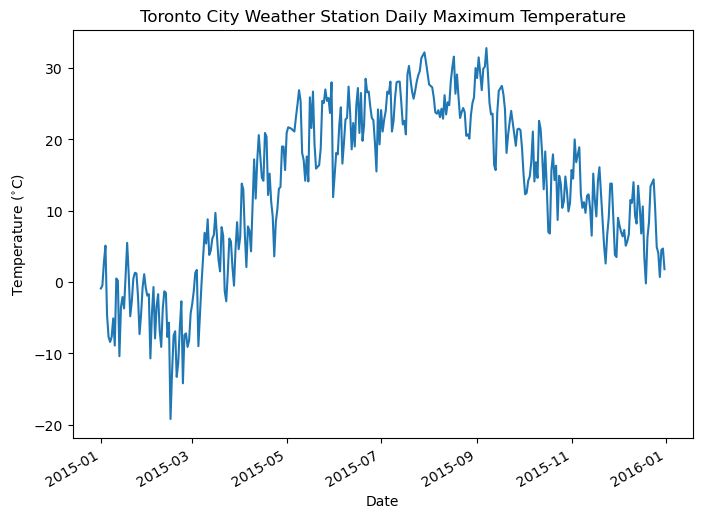

In [11]:
plt.figure(figsize = (8, 6))
df_toronto_city[df_toronto_city.index.year == 2015]['MaxTemp'].plot()
plt.title("Toronto City Weather Station Daily Maximum Temperature")
plt.ylabel(r"Temperature ($^{\circ}$C)")
plt.show()

Now we can really see the day-to-day variations in temperature, as well as the seasonal cycle. There was evidently a a few warm days early in the year, and a short cold spell in early May, but otherwise, we see the temperature rising into the summer, peaking in July and August, and then falling again in the winter.


## 3.1.2 Seasonal Cycles and Climatologies

To get an idea of the typical seaosonal cycle of temperaure, we can calculate the *daily climatology* of the daily maximum temperature. What this means is we calculate a long-term average for each day of the year.  We can do this using the ``groupby`` functionality of Pandas, taking advantage of the ``dayofyear`` attribute of the pd.Datetime datatype we converted the date values to in the function ``download_station_data``.

Because we're taking a long-term average, the plot will be much smoother, since we're averaging out much of the noise that makes up the day-to-day variability, like we see in the plot of one specific year. To get an idea of what typical variations look like, we can also calculate the standard deviation of temperature for each day, across all years, and add it to our plot as shading.

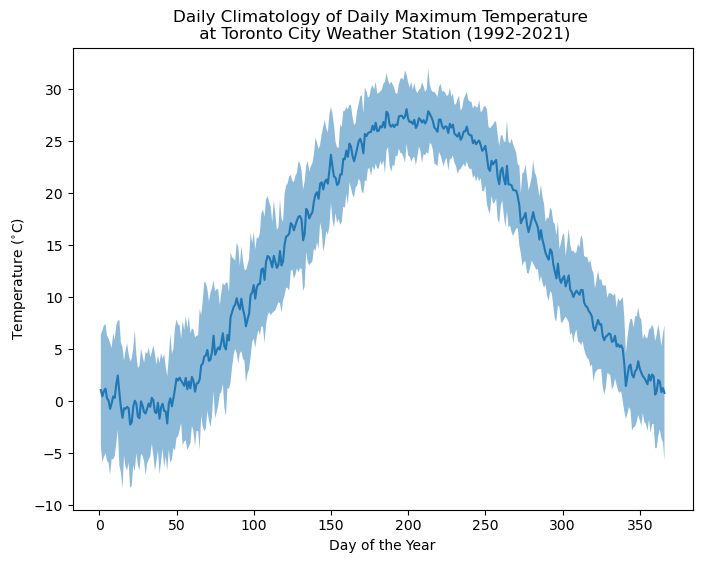

In [12]:
# calculate long-term mean and standard deviation for each day of the year, for the 30-year period
tmax_toronto_clim_avg = df_toronto_city['MaxTemp'].groupby(df_toronto_city.index.dayofyear).mean()
tmax_toronto_clim_std = df_toronto_city['MaxTemp'].groupby(df_toronto_city.index.dayofyear).std()

# make some variables with short names to pass to maptlotlib plotting functions
x = tmax_toronto_clim_avg.index.values # time values - the day of the year
y = tmax_toronto_clim_avg.values # daily max temperature climatology
ymax = y + tmax_toronto_clim_std.values # lower shading range 
ymin = y - tmax_toronto_clim_std.values # upper shading range

# plot
plt.figure(figsize = (8, 6))
plt.title("Daily Climatology of Daily Maximum Temperature \n at Toronto City Weather Station (1992-2021)")
# the \n is a line break, included since the title is a bit long
plt.ylabel(r"Temperature ($^{\circ}$C)")
plt.xlabel("Day of the Year")

plt.plot(x, y) # plot 
plt.fill_between(x, ymin, ymax, alpha = 0.5) 
# the 'alpha' kwarg sets the opacity of the shading (1 means totally opaque)
plt.show()

While this plot isn't perfectly smooth, the day-to-day variations in the solid line are smaller than in the time series for the year 2015, because of the long-term averaging. The shading represents the typical range of temperatures for each day. It's important to note that grouped averaging for each day of the year individually isn't the only way to calculate a climatology. A method that could give a smoother result would be to first calculate a rolling average of the data (i.e. 7-day rolling mean) before taking the long-term mean or standard deviation. This is valid, since there isn't a good reason why the typical temperature range for a given day should be meaningfully different than for the rest of the week. 

Let's calculate the climatology for daily maximum temperature at Toronto using this alternative method. We can see that it indeed produces a smoother mean curve, with a similar overall range of temperatures for each day.


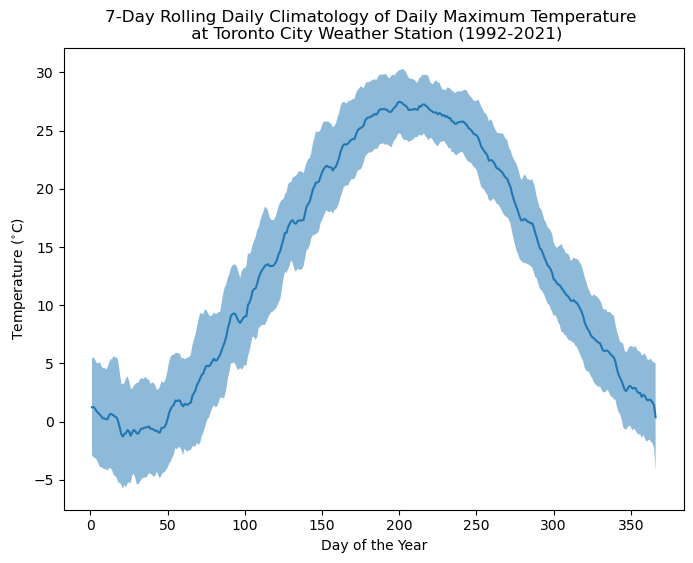

In [13]:
# calculate long-term mean and standard deviation for each day of the year, for the 30-year period
n_roll = 7 # rolling mean window size

# climatological average
tmax_toronto_rollingmean = df_toronto_city['MaxTemp'].rolling(n_roll).mean()
tmax_toronto_clim_avg_rolling = tmax_toronto_rollingmean.groupby(tmax_toronto_rollingmean.index.dayofyear).mean()

# we need to be careful about how to get the standard deviation - we don't want the standard deviation of the 
# rolling mean, we want the standard deviation across all days in the n-day-of-year window. 
# we can do this by calculating the mean variance for each n-day window, and then taking the square root 
# to get the standard deviation. This works because variances add linearly.
tmax_toronto_rollingvar = df_toronto_city['MaxTemp'].rolling(n_roll).var()
tmax_toronto_clim_var_rolling = tmax_toronto_rollingvar.groupby(tmax_toronto_rollingvar.index.dayofyear).mean()
tmax_toronto_clim_std_rolling = np.sqrt(tmax_toronto_clim_var_rolling)

x = tmax_toronto_clim_avg_rolling.index.values 
y = tmax_toronto_clim_avg_rolling.values # daily max temperature climatology
ymax = y + tmax_toronto_clim_std_rolling.values # lower shading range 
ymin = y - tmax_toronto_clim_std_rolling.values # upper shading range

# plot
plt.figure(figsize = (8, 6))
plt.title(f"{n_roll}-Day Rolling Daily Climatology of Daily Maximum Temperature " + \
          "\n at Toronto City Weather Station (1992-2021)")
plt.ylabel(r"Temperature ($^{\circ}$C)")
plt.xlabel("Day of the Year")

plt.plot(x, y) # plot 
plt.fill_between(x, ymin, ymax, alpha = 0.5) 
plt.show()

Temperature has a strong and relatively obvious seasonal cycle. But what about other climate variables, like precipitation? Let's do the same analysis that we just did for daily maximum temperature, for daily total precipitation amounts.

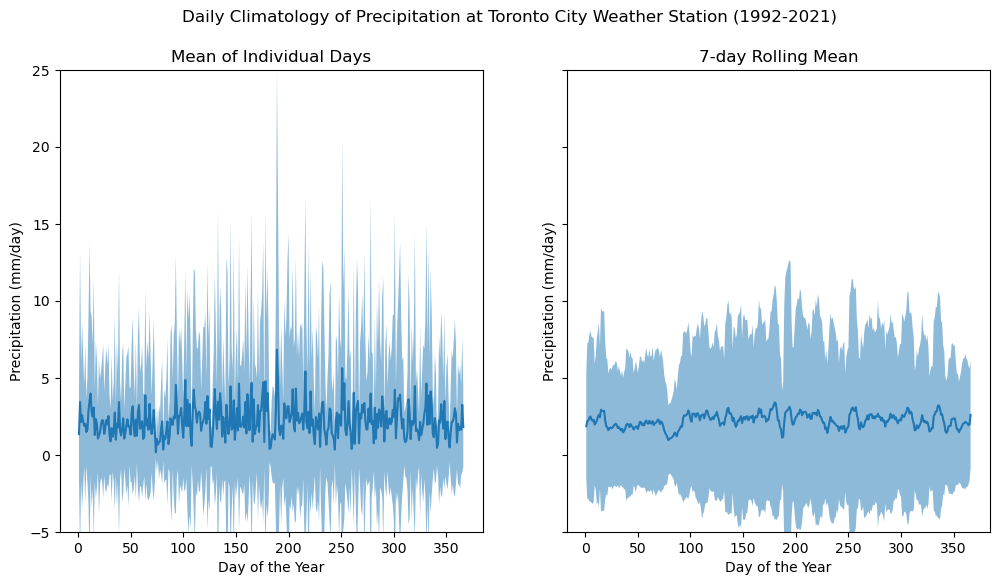

In [14]:
# calculate long-term mean and standard deviation for each day of the year, for the 30-year period

# direct averaging of each day separately
precip_toronto_clim_avg = df_toronto_city['TotalPrecip'].groupby(df_toronto_city.index.dayofyear).mean()
precip_toronto_clim_std = df_toronto_city['TotalPrecip'].groupby(df_toronto_city.index.dayofyear).std()


# 7-day rolling average
n_roll = 7
precip_toronto_rollingmean = df_toronto_city['TotalPrecip'].rolling(n_roll).mean()
precip_toronto_clim_rollingavg = precip_toronto_rollingmean.groupby(precip_toronto_rollingmean.index.dayofyear).mean()

# stdev
precip_toronto_rollingvar = df_toronto_city['TotalPrecip'].rolling(n_roll).var()
precip_toronto_clim_var_rolling = precip_toronto_rollingvar.groupby(precip_toronto_rollingvar.index.dayofyear).mean()
precip_toronto_clim_std_rolling = np.sqrt(precip_toronto_clim_var_rolling)

clim_avgs = (precip_toronto_clim_avg, precip_toronto_clim_rollingavg)
clim_stds = (precip_toronto_clim_std, precip_toronto_clim_std_rolling)

# two-panel figure
fig, axes = plt.subplots(ncols = 2, figsize = (12,6), sharey = True, sharex = True)

# plot
fig.suptitle("Daily Climatology of Precipitation at Toronto City Weather Station (1992-2021)")
for i, (avg, std) in enumerate(zip(clim_avgs, clim_stds)):
    x = avg.index.values
    y = avg.values
    ymax = y + std.values
    ymin = y - std.values
    axes[i].plot(x, y) # plot 
    axes[i].fill_between(x, ymin, ymax, alpha = 0.5) 
    axes[i].set_ylabel(r"Precipitation (mm/day)")
    axes[i].set_xlabel("Day of the Year")
    axes[i].set_ylim(-5,25)

axes[0].set_title("Mean of Individual Days")
axes[1].set_title(f"{n_roll}-day Rolling Mean")

plt.show()

The daily climatology of precipitation at this station clearly looks much different from that of temperature. There are no major swings over the course of the year, which means that it may be less important to account for the time of year when doing analysis with precipitation (unlike temperature, where conditions in winter are much different than for summer).

Next, even after applying the 7-day rolling mean, the day-to-day variations are much less smooth than for temperature. One reason for this is that precipitation is very much an "on-or-off" phenomenon - many days will have zero precipitation, but when it does precipitate, there can be very large amounts (i.e. extreme values) which affect the long-term mean for that day.

Finally, it looks like the method of estimating the typical range of values using $\pm$ one standard deviation produces negative values at the lower end of the range, which is unphysical. This last issue can be resolved by choosing a different method for characterizing the range of typical values. One such method is to use a range of *percentiles* (also called *quantiles*) as the upper and lower bounds for the typical range (i.e. 10th-90th percentile). This is how [climatedata.ca](https://climatedata.ca/) (a source of observational data and post-processed climate model output for Canada) reports the typical ranges of variability for climate data.

## 3.1.3 Extreme Values

Weather outside of the typical range of variability, termed "extreme weather" is often of interest for climate-sensitive domain applications. Extreme temperatures can elevate building energy use due to air conditioning and heating. Extreme precipitation can cause flooding and damage to infrastructure near water basins or rivers, and extreme wind speeds can damage bridges, power lines, and other infrastructure. 

There are two broad-strokes categories of methods by which extreme values of climate variables are quantified. The first is a **peaks over threshold** (POT) approach, by which values above (or below) some pre-determined threshold are considered to be extreme events. For example, when calculating the climate index "Tropical Nights", we consider extreme warm days to be those with daily minimum temperature above 20$^{\circ}$C. The threshold need not be a single fixed value - for many applications it is common to use a certain percentile value (i.e. the 95th percentile) as a threshold for defining extreme values, based on the distribution of the climate variable for a particular location. This allows one to tailor the threshold to the local climate, which is often how infrastructure is designed in practice.

The second approach to quantifying extreme values is the **block maxima** method. Under this paradigm, we subdivide the data record into non-overlapping "blocks" of time (usually one year), and take the maximum (or minimum) value for each block. Practitioners often characterize the intensity of extreme weather using the $N$-year **return period value** of a climate variable, which is calculated using the block maxima method. The $N$-year return period value is the value which, in each year, has an exceedance probability of $1/N$. The return period $N$ is usually 50, 100, or even 1000 years, and the longer the return period, the greater the return period value. Return period values are commonly used when planning the expected lifetime of infrastructure. If we want a bridge to last 100 years, then it should be designed to withstand wind speeds of up to the 100 year return value.

Statistical extreme value theory tells us that block maxima follow a probability distribution called the [Generalized Extreme Value](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) (GEV) distribution. Fitting a time series of annual maxima of the variable $x$ to a GEV distribution, we can estimate the CDF of this distribution $F(x)$, and calculate the return value $x_{N}$ as 

$$x_{N} = F^{-1}\left(1 - \frac{1}{N}\right)$$

As an example, let's calculate the 50-year return period value of daily total precipitation at the Toronto City weather station. Since we were previously only working with 30 years of data, which is rather short for studying extreme events (which are by definition uncommon), we'll re-download the record for this station extending back to 1950

In [15]:
# download data for this station for an earlier period
df_1950_1991 = download_station_data(stn_ids_toronto_city[0], years = range(1950, 1992))

# stitch together with what we had already
df_toronto_city_longrecord = pd.concat([df_1950_1991, df_toronto_city])                                 

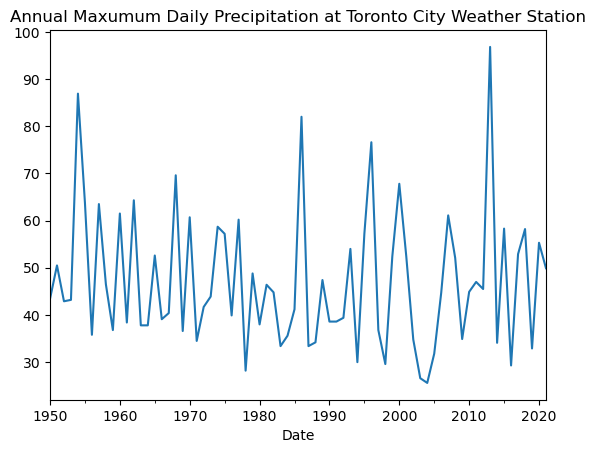

In [16]:
# get annual maximum precipitation values and plot
precip_toronto_annmax = df_toronto_city_longrecord['TotalPrecip'].resample('1Y').max()

plt.figure()
plt.title("Annual Maxumum Daily Precipitation at Toronto City Weather Station")
precip_toronto_annmax.plot()
plt.show()


In [17]:
# parameter estimates for GEV distribution
gev_params = stats.genextreme.fit(precip_toronto_annmax.values)

# 50-year return period value
N_return = 50
precip_50yr_return = stats.genextreme.ppf(1 - (1/N_return), *gev_params) 
# ppf is the 'percent point function' - another name for the inverse CDF F^{-1}

print(precip_50yr_return)

87.50195232590536


This very quick analysis has shown that the 50-year return value of daily precipitation for Toronto is about 87 mm. As a sanity check, the time series of annual maximum values for the 71 year period 1950-2021 has a peak value of just under 100 mm, so 87 mm could plausibly have a one-in-50 chance of occurrence in any given year. 

This analysis assumes that the distribution of precipitation in Toronto is *stationary* for the entire period used for calculation. In other words, there is no trend in the frequency or intensity of extreme events in the study period. When considering how climate change affects return period values of a climate variable, one would need to allow for  time-dependence of the GEV parameters (or dependance on the level of global warming, to avoid dependance on the future forcing scenario). This more advanced method is outside the scope of this Guidebook. A simple alternative is to focus the future analysis on a time period distinct from the historical period used to establish the baseline climate.

## Summary

This section of the Guidebook has introduced you to working with climate data from weather station observations. While useful for many impact studies, some applications require data with coverage over some larger spatial domain. The following section will introduce you to gridded observational data products, and how to download and analyze them.

## Appendix: Other Sources of Station Data

This notebook focused only on ECCC Weather Station data for Canada. For studies outside of Canada that require station observations, you'll of course need alternate sources of data. One such dataset is the [Global Historical Climatology Network - Daily](https://doi.org/10.7289/V5D21VHZ), which is a database of station observations across the world. Python packages for downloading this data exist, but have not yet been tested or implemented by the UTCDW developers. Sub-daily station observations can be found by searching the [NOAA Climate Data Online database](https://www.ncdc.noaa.gov/cdo-web/search). Other sources of station data certainly exist, but intstructions for accessing them are outside the current scope of this guide.